Имеется информация о числе заказов за прошедшие 3 месяца с разрешением по неделям. Построим прогноз продаж на следующие 3 месяца, с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%         
_________
P.S. В действительности на таком малом кол-ве данных строить прогноз не имеет смысла, но ради академического опыта построим :3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import holidays
from fbprophet import Prophet

In [2]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/426638/test2_completed.csv', 
                   parse_dates=['Дата'])
data.columns = ['ds', 'y']
data

,ds,y
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489
5,2020-02-09,1823
6,2020-02-16,1991
7,2020-02-23,2166
8,2020-03-01,2334
9,2020-03-08,2607


In [3]:
# Т.к. в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%, то для точности 
# прогноза уберем эти 7% 'привлеченных' заказов  для "2020-02-09" - теперь в нашем датасете будут только данные 
# для органики.

data.y = data.y.astype('float')
data.iloc[5,1] = data.iloc[5,1] / 1.07
data

,ds,y
0,2020-01-05,650.000000
1,2020-01-12,837.000000
2,2020-01-19,1020.000000
3,2020-01-26,1176.000000
4,2020-02-02,1489.000000
5,2020-02-09,1703.738318
6,2020-02-16,1991.000000
7,2020-02-23,2166.000000
8,2020-03-01,2334.000000
9,2020-03-08,2607.000000


[Text(0, 0, '2019-12-27'),
 Text(0, 0, '2020-01-16'),
 Text(0, 0, '2020-02-05'),
 Text(0, 0, '2020-02-25'),
 Text(0, 0, '2020-03-16'),
 Text(0, 0, '2020-04-05')]

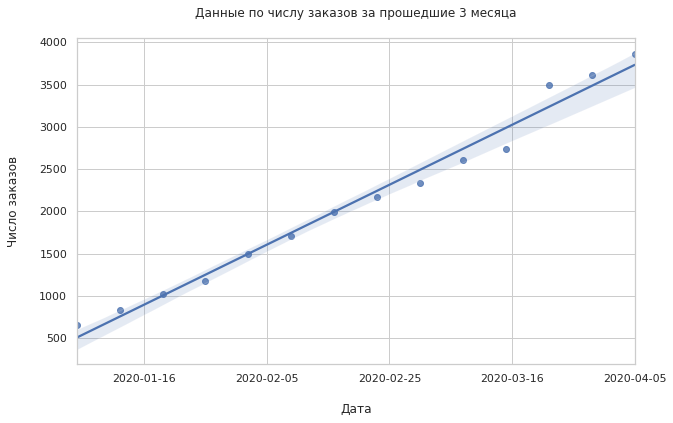

In [4]:
# Для наглядности визуализируем те данные, что у нас имеются:

data1 = data.copy()
data1['date_ordinal'] = pd.to_datetime(data1['ds']).apply(lambda x: \
        x.toordinal())

sns.set(style='whitegrid', rc={'figure.figsize': (10, 6)})

ax = sns.regplot(x='date_ordinal', y='y', data=data1)

# Настройка подписей осей:
ax.set_title('Данные по числу заказов за прошедшие 3 месяца\n')
ax.set_xlabel('\nДата')
ax.set_ylabel('Число заказов\n')

new_labels = [date.fromordinal(int(i)) for i in ax.get_xticks()]
ax.set_xticklabels(new_labels)


Невооруженным глазом видно, что наши данные имеют близкую к линейной зависимость, и, несмотря на то, что данных мало, можно
попробовать построить прогноз временного ряда с помощью FBprohet.

In [5]:
# При построении прогноза будем учитывать влияние праздников (RU). Для этого сформирует датафрейм 
# с праздниками за нужный период:

holidays_dict = holidays.RU(years=(2020))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient="index").reset_index()
df_holidays = df_holidays.rename({"index": "ds", 0: "holiday"}, axis="columns")
df_holidays["ds"] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=["ds"])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays = df_holidays.iloc[4:].reset_index(drop=True)

df_holidays

,ds,holiday
0,2020-01-05,Новый год
1,2020-01-06,Новый год
2,2020-01-07,Православное Рождество
3,2020-01-08,Новый год
4,2020-02-23,День защитника отечества
5,2020-03-08,День женщин
6,2020-05-01,Праздник Весны и Труда
7,2020-05-09,День Победы
8,2020-06-12,День России
9,2020-11-04,День народного единства


In [6]:
# Проверим качество модели, отрезав от датафрейма данные последних пяти недель и предсказав их:

predictions = 5
train_df = data[:-predictions]

# Праздники, которые будем учитывать:
df_holidays_train = df_holidays.iloc[:6].reset_index(drop=True)

# Строим прогноз:
m = Prophet(
    holidays=df_holidays_train,
    interval_width=0.95,
    n_changepoints=6,
    yearly_seasonality=False,
    daily_seasonality=False,
    weekly_seasonality=False,
)
m.fit(train_df)

future = m.make_future_dataframe(periods=predictions, freq="W")
forecast = m.predict(future)

# Датафрейм с прогнозом:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]


,ds,yhat,yhat_lower,yhat_upper
0,2020-01-05,650.013056,575.340147,724.751573
1,2020-01-12,805.276259,732.733943,877.244871
2,2020-01-19,1028.618571,954.010843,1106.595987
3,2020-01-26,1251.960883,1181.141278,1326.374442
4,2020-02-02,1475.331938,1398.031466,1543.060399
5,2020-02-09,1698.702992,1624.027479,1774.918588
6,2020-02-16,1922.074047,1853.093107,1993.654209
7,2020-02-23,2165.950088,2091.911134,2242.090781
8,2020-03-01,2368.777492,2296.205562,2439.781203
9,2020-03-08,2592.129215,2516.222748,2665.243600


In [7]:
# Считаем ошибку модели (насколько в среднем отличаются наши предсказанные значения от реальных):

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(data.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

# Здесь, если не учитывать влияние праздников, MAPE ~ 7.41%, т.е. влияние праздников хоть и небольшое, но качество модели 
# чуть-чуть лучше, поэтому прогноз на следующие 3 месяца будем строить с праздниками.

MAPE (средняя абсолютная ошибка в процентах) –  7.148718688845453 %
MAE (средняя абсолютная ошибка) –  253.35971518585703


In [8]:
# Теперь строим прогноз на следующие 3 месяца (уже на основе всех имеющихся данных):

predictions = 13

m = Prophet(
    holidays=df_holidays,
    interval_width=0.95,
    n_changepoints=10,
    yearly_seasonality=False,
    daily_seasonality=False,
    weekly_seasonality=False,
)
m.fit(data)
future = m.make_future_dataframe(periods=predictions,freq='W')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'additive_terms']]

,ds,yhat,yhat_lower,yhat_upper,additive_terms
0,2020-01-05,650.001076,427.195078,877.720776,188.715167
1,2020-01-12,716.842772,471.267011,933.112371,0.000000
2,2020-01-19,972.399635,750.819104,1198.236387,0.000000
3,2020-01-26,1227.956498,1007.570190,1441.618601,0.000000
4,2020-02-02,1483.513362,1234.641927,1712.671074,0.000000
5,2020-02-09,1739.070226,1513.241301,1968.790508,0.000000
6,2020-02-16,1994.627194,1770.648977,2216.072143,0.000000
7,2020-02-23,2166.003156,1936.224877,2395.162558,-84.187015
8,2020-03-01,2505.757387,2277.499901,2733.523627,0.000000
9,2020-03-08,2606.997778,2388.011728,2836.445988,-154.347812


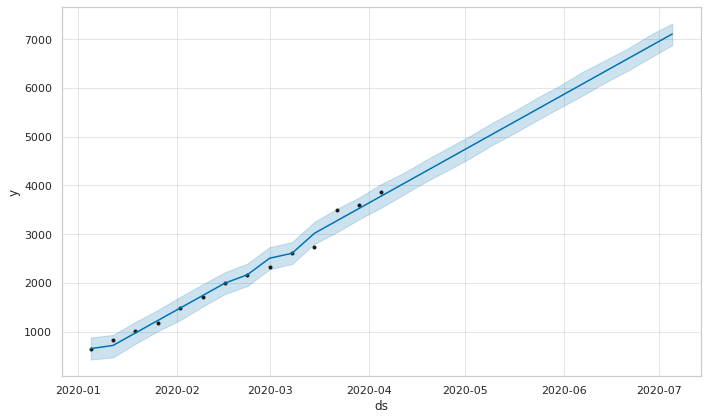

In [9]:
fig = m.plot(forecast)

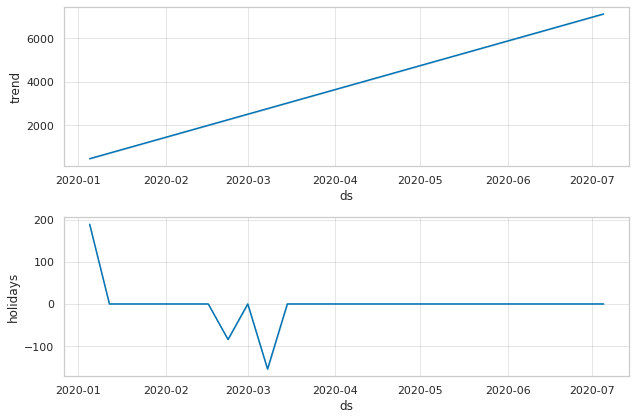

In [10]:
fig = m.plot_components(forecast)

Итак, fbprophet построил нам наш прогноз по линейной зависимости. Также необходимо отметить влияние праздников: 8 марта и 23 февраля отрицательно влияют на число заказов, причем 8ое марта сильнее - заказов в эти дни меньше, а новогодние праздники - положительно. Непосредственно на нашем прогнозе это никак не сказывается, но может быть полезным в будущем. В реальности рост числа заказов скорее всего не будет линейным (или будет ~ таковым только ограниченное время)(??)

In [12]:
# Напоследок визуализируем наш прогноз с границами :

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=data['ds'], y=data['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])